# Measure distance to a center line
A common question is how to determine distances of points to the center of a segmented object. For this we can skeletonize the object, produce a distance map and read out intensities from the distance map at the given points to determine their distance to the skeleton / center line.

See also:
* https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html
* https://examples.itk.org/src/filtering/distancemap/maurerdistancemapofbinary/documentation
* https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.distance_transform_edt.html

In [1]:
from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_simpleitk_image_processing as nsitk
import numpy as np
import stackview
import pyclesperanto_prototype as cle

## Starting point: a binary image
We start using a binary image that looks like an arm.

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
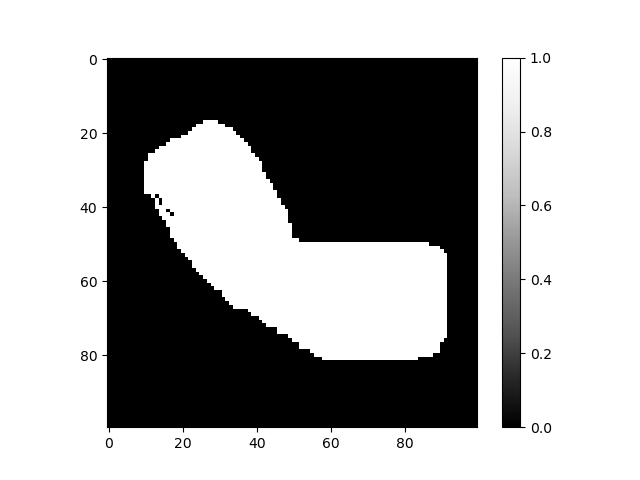
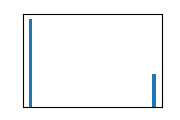

In [2]:
binary_arm = imread("../../data/binary_arm.tif")
stackview.insight(binary_arm)

Furthermore, we continue with a list of coordinates in X/Y format:

In [3]:
coordinates_xy = np.asarray([
                  [70, 80],
                  [70, 70],
                  [70, 60]]).T

We next produce a label image where the given coordinates are labeled. The first coordinate (index=0 in the list) will be labeled with 1, the second with 2, and so on. Background pixels are 0. 
We use this label image for visualization and further down, we will also use this image to do the measurement.

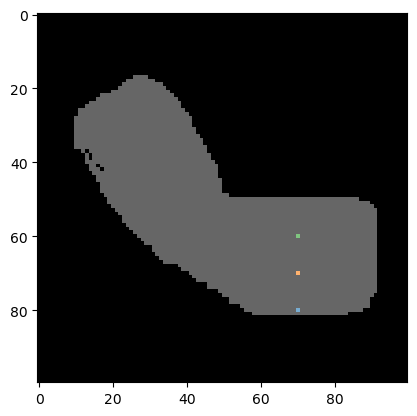

In [4]:
# draw the coordinates into an image; for visualization purposes
blank_image = cle.create((binary_arm.shape))
labeled_spots = coordinate_visualization = cle.pointlist_to_labelled_spots(coordinates_xy, blank_image)

# show the labeled pixels on top of the binary image
cle.imshow(binary_arm, continue_drawing=True, max_display_intensity=1)
cle.imshow(labeled_spots, labels=True, alpha=0.6)

## Pre-processing
Before we can skeletonize the image, we need to fill the black holes in the white area.

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
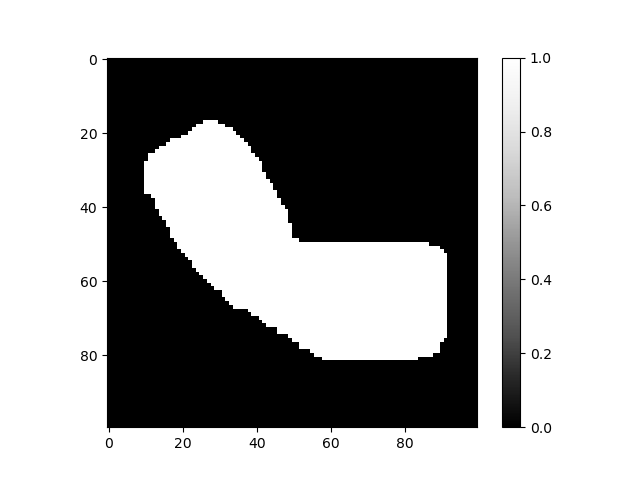
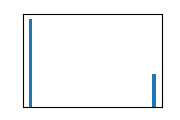

In [5]:
filled_holes = nsitk.binary_fill_holes(binary_arm)
filled_holes

## Skeletonization
The [skeleton of a binary image](https://scikit-image.org/docs/stable/auto_examples/edges/plot_skeleton.html) is a thin line in the center of white areas.

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  ...,
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False],
                  [False, False, False, ..., False, False, False]])
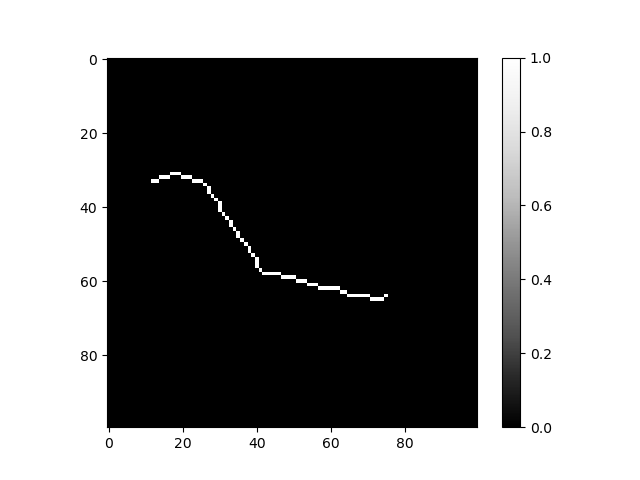
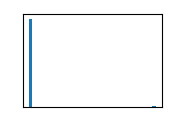

In [6]:
skeleton = nsbatwm.skeletonize(filled_holes)
skeleton

## Distance map
We next draw a Signed Maurer Distance Map. Distance maps are images where the intensity represents the distance of a pixel to the next white pixel in the binary image from which the distance map was generated from.

StackViewNDArray([[-34.928497, -34.539833, -34.176014, ..., -67.6757  ,
                   -68.007355, -68.35203 ],
                  [-34.0147  , -33.61547 , -33.24154 , ..., -66.730804,
                   -67.06713 , -67.41662 ],
                  [-33.105892, -32.695564, -32.31099 , ..., -65.78754 ,
                   -66.12866 , -66.48308 ],
                  ...,
                  [-57.280014, -56.568542, -55.86591 , ..., -39.40812 ,
                   -40.      , -40.60788 ],
                  [-57.982758, -57.280014, -56.568542, ..., -40.22437 ,
                   -40.804413, -41.400482],
                  [-58.694122, -57.982758, -57.280014, ..., -41.04875 ,
                   -41.617306, -42.201897]], dtype=float32)
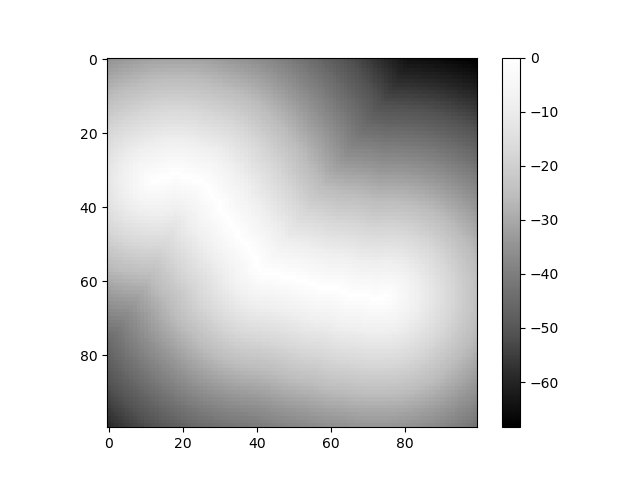
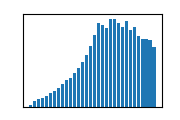

In [7]:
distance_map = nsitk.signed_maurer_distance_map(skeleton)
distance_map

Using [`stackview.picker`](https://github.com/haesleinhuepf/stackview#pick-intensities) we can hover with the mouse over the image and read out intensities. This only works in a Jupyter-like environment.

In [8]:
stackview.picker(distance_map, zoom_factor=3)

## Measurements
We now can read out the intesity in the distance map at the given locations of the labeled spots.

In [9]:
values_at_positions = cle.read_intensities_from_positions(coordinates_xy, distance_map)
np.asarray(values_at_positions)

array([[-15.033297 ,  -5.0990195,  -4.       ]], dtype=float32)

## Exercise
Use the distance map on the `binary_arm` image to determine the distance of the three points from the edge of the arm, instead of the center line.